### Ładowanie danych

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

iris = load_iris(as_frame=True)
wine = load_wine(as_frame=True)
glass = {}
glass['data'] = pd.read_csv('glass.data', index_col=0, header=None, names=[
    'Id', 'RI', 'Na', 'Mg',
    'Al', 'Si', 'K', 'Ca',
    'Ba', 'Fe', 'target'
])
glass['target'] = glass['data']['target']
glass['data'] = glass['data'].drop(columns=['target'])
seeds = {}
seeds['data'] = pd.read_csv('seeds_dataset.txt', sep='\t', header=None, names=[
    'area',
    'perimeter',
    'compactness',
    'length_of_kernel',
    'width_of_kernel',
    'asymmetry_coefficient',
    'length_of_kernel_groove',
    'target'
])
seeds['target'] = seeds['data']['target']
seeds['data'] = seeds['data'].drop(columns=['target'])

### Implememntacja Dunn

In [2]:
def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)

def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)

def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

def dunn_score(X, labels):
    clusters = [
        X[labels == label].values for label in np.unique(labels)
    ]
    return dunn(clusters)

### Implementacja Purity

In [3]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

### Implementacja wykresów

In [4]:
import seaborn as sns

def make_plot(dataset):
    pca = PCA(2)
    data = pca.fit_transform(dataset['data'])
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=dataset['target'])

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull
from scipy import interpolate

def plot_clusterization(dataset, y_true, model, title):
    fig, ax = plt.subplots(1,2 , figsize=(14,6))
    
    pca = PCA(2)
    data = pca.fit_transform(dataset['data'])
    clusters_centers = pca.transform(model.cluster_centers_)
        
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=model.labels_,
                   alpha=1.0, edgecolor="black",ax=ax[0])
    ax[0].scatter(clusters_centers[:, 0], clusters_centers[:, 1], marker='^', c=np.unique(model.labels_), s=200,
               cmap=plt.get_cmap('Set1'))
    
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y_true,
                   alpha=1.0, edgecolor="black",ax=ax[1])
    ax[1].scatter(clusters_centers[:, 0], clusters_centers[:, 1], marker='^', c=np.unique(model.labels_), s=200,
               cmap=plt.get_cmap('Set1'))

    
    for i in np.unique(model.labels_):
        points = data[model.labels_ == i]
        try:
            hull = ConvexHull(points)
            x_hull = np.append(points[hull.vertices,0],
                               points[hull.vertices,0][0])
            y_hull = np.append(points[hull.vertices,1],
                               points[hull.vertices,1][0])

            dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
            dist_along = np.concatenate(([0], dist.cumsum()))
            spline, u = interpolate.splprep([x_hull, y_hull], 
                                            u=dist_along, s=0)
            interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
            interp_x, interp_y = interpolate.splev(interp_d, spline)

            ax[0].fill(interp_x, interp_y, '--', alpha=0.2)
            ax[1].fill(interp_x, interp_y, '--', alpha=0.2)
        except Exception:
            pass
    ax[0].set_title('PREDICTIONS',fontsize=16)
    ax[1].set_title('TRUE LABELS',fontsize=16)

    fig.suptitle(title, fontsize=16)
    plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

def PAM_parameters(dataset):
    n_clusters = range(2, 20)
    db = []
    silhouette = []
    dunn = []
    purity = []
    for n in n_clusters:
        model = KMedoids(n_clusters=n, method='pam')
        preds = model.fit_predict(dataset['data'])
        db.append(davies_bouldin_score(dataset['data'], preds))
        silhouette.append(silhouette_score(dataset['data'], preds))
        dunn.append(dunn_score(dataset['data'], preds))
        purity.append(purity_score(dataset['target'], preds))
    fig, ax = plt.subplots(4, sharex=True)
    ax[0].plot(n_clusters, db)
    ax[1].plot(n_clusters, silhouette)
    ax[2].plot(n_clusters, dunn)
    ax[3].plot(n_clusters, purity)
    ax[0].set_ylabel('Davies-Bouldin')
    ax[1].set_ylabel('Silhouette')
    ax[2].set_ylabel('Dunn')
    ax[3].set_ylabel('Purity')
    ax[3].set_xlabel('n_clusters')
    fig.set_size_inches(9.6, 19.2)
    fig.suptitle('PAM', fontsize=16)
    
    model = KMedoids(n_clusters=n, method='pam')
    preds = model.fit_predict(dataset['data'])
    
    print('No standarization')
    print('Davies-Bouldin:', davies_bouldin_score(dataset['data'], preds))
    print('Silhouette:', silhouette_score(dataset['data'], preds))
    print('Dunn:', dunn_score(dataset['data'], preds))
    print('Purity:', purity_score(dataset['target'], preds))
    
    scaler = StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(dataset['data']))
    model = KMedoids(n_clusters=n, method='pam')
    preds = model.fit_predict(data)
    
    print('\nWith standarization')
    print('Davies-Bouldin:', davies_bouldin_score(data, preds))
    print('Silhouette:', silhouette_score(data, preds))
    print('Dunn:', dunn_score(data, preds))
    print('Purity:', purity_score(dataset['target'], preds))
    print('\n-----------------------\n')
    
    model = KMedoids(n_clusters=n, method='pam')
    preds = model.fit_predict(dataset['data'])
    
    print('Euclidean metric')
    print('Davies-Bouldin:', davies_bouldin_score(dataset['data'], preds))
    print('Silhouette:', silhouette_score(dataset['data'], preds))
    print('Dunn:', dunn_score(dataset['data'], preds))
    print('Purity:', purity_score(dataset['target'], preds))
    
    model = KMedoids(n_clusters=n, method='pam', metric='l1')
    preds = model.fit_predict(dataset['data'])
    
    print('\nManhattan metric')
    print('Davies-Bouldin:', davies_bouldin_score(dataset['data'], preds))
    print('Silhouette:', silhouette_score(dataset['data'], preds, metric='l1'))
    print('Dunn:', dunn_score(dataset['data'], preds))
    print('Purity:', purity_score(dataset['target'], preds))
    
    model = KMedoids(n_clusters=n, method='pam', metric='chebyshev')
    preds = model.fit_predict(dataset['data'])
    
    print('\nChebyshev metric')
    print('Davies-Bouldin:', davies_bouldin_score(dataset['data'], preds))
    print('Silhouette:', silhouette_score(dataset['data'], preds, metric='chebyshev'))
    print('Dunn:', dunn_score(dataset['data'], preds))
    print('Purity:', purity_score(dataset['target'], preds))

In [7]:
def KMeans_parameters(dataset):
    fig, ax = plt.subplots(4, 3, sharex='col', sharey='row')
    
    n_clusters = range(2, 20)
    db = []
    silhouette = []
    dunn = []
    purity = []
    for n in n_clusters:
        model = KMeans(n_clusters=n)
        preds = model.fit_predict(dataset['data'])
        db.append(davies_bouldin_score(dataset['data'], preds))
        silhouette.append(silhouette_score(dataset['data'], preds))
        dunn.append(dunn_score(dataset['data'], preds))
        purity.append(purity_score(dataset['target'], preds))
    ax[0,0].plot(n_clusters, db)
    ax[1,0].plot(n_clusters, silhouette)
    ax[2,0].plot(n_clusters, dunn)
    ax[3,0].plot(n_clusters, purity)
    
    n_init = range(2, 20)
    db = []
    silhouette = []
    dunn = []
    purity = []
    for n in n_init:
        model = KMeans(n_init=n)
        preds = model.fit_predict(dataset['data'])
        db.append(davies_bouldin_score(dataset['data'], preds))
        silhouette.append(silhouette_score(dataset['data'], preds))
        dunn.append(dunn_score(dataset['data'], preds))
        purity.append(purity_score(dataset['target'], preds))
    # fig, ax = plt.subplots()
    ax[0,1].plot(n_clusters, db)
    ax[1,1].plot(n_clusters, silhouette)
    ax[2,1].plot(n_clusters, dunn)
    ax[3,1].plot(n_clusters, purity)
    
    max_iter = range(2, 20)
    db = []
    silhouette = []
    dunn = []
    purity = []
    for n in max_iter:
        model = KMeans(max_iter=n)
        preds = model.fit_predict(dataset['data'])
        db.append(davies_bouldin_score(dataset['data'], preds))
        silhouette.append(silhouette_score(dataset['data'], preds))
        dunn.append(dunn_score(dataset['data'], preds))
        purity.append(purity_score(dataset['target'], preds))
    ax[0,2].plot(max_iter, db)
    ax[1,2].plot(max_iter, silhouette)
    ax[2,2].plot(max_iter, dunn)
    ax[3,2].plot(max_iter, purity)
    
    ax[0,0].set_ylabel('Davies-Bouldin')
    ax[1,0].set_ylabel('Silhouette')
    ax[2,0].set_ylabel('Dunn')
    ax[3,0].set_ylabel('Purity')
    ax[3,0].set_xlabel('n_clusters')
    ax[3,1].set_xlabel('n_init')
    ax[3,2].set_xlabel('max_iter')
    fig.set_size_inches(19.2, 19.2)
    fig.suptitle('KMeans', fontsize=16)

# Iris

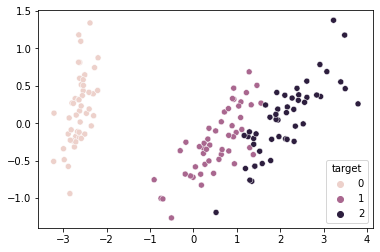

In [8]:
make_plot(iris)

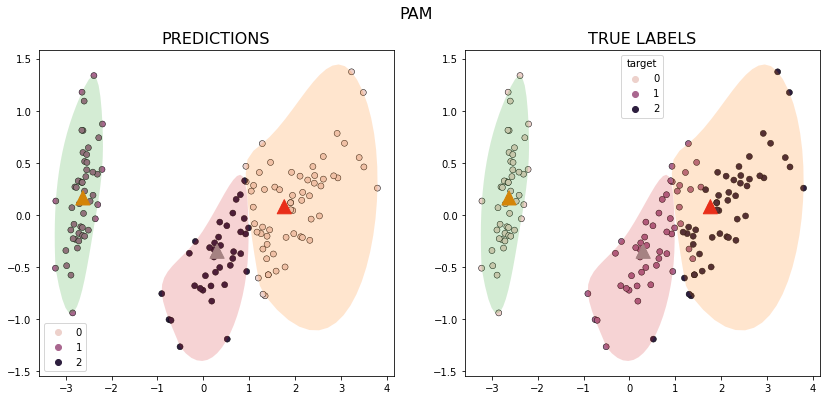

Davies-Bouldin: 0.6686244410428932
Silhouette: 0.5201984013106988
Dunn: 0.04759207562729504
Purity: 0.9066666666666666


In [9]:
model = KMedoids(n_clusters=iris['target'].nunique(), method='pam')
model.fit(iris['data'])
preds = model.predict(iris['data'])
plot_clusterization(iris, iris['target'], model, 'PAM')
print('Davies-Bouldin:', davies_bouldin_score(iris['data'], preds))
print('Silhouette:', silhouette_score(iris['data'], preds))
print('Dunn:', dunn_score(iris['data'], preds))
print('Purity:', purity_score(iris['target'], preds))

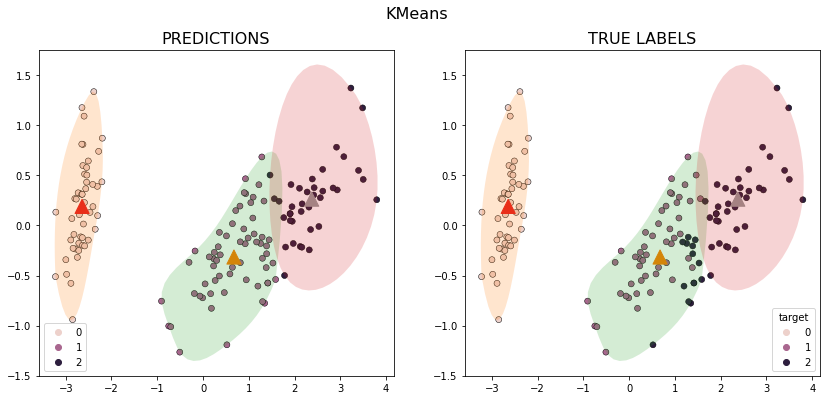

Davies-Bouldin: 0.6619715465007511
Silhouette: 0.5528190123564102
Dunn: 0.09880739332808099
Purity: 0.8933333333333333


In [10]:
model = KMeans(n_clusters=iris['target'].nunique())
model.fit(iris['data'])
plot_clusterization(iris, iris['target'], model, 'KMeans')
preds = model.predict(iris['data'])
print('Davies-Bouldin:', davies_bouldin_score(iris['data'], preds))
print('Silhouette:', silhouette_score(iris['data'], preds))
print('Dunn:', dunn_score(iris['data'], preds))
print('Purity:', purity_score(iris['target'], preds))

Dla Iris PAM daje trochę lepsze rezultaty niż KMeans

No standarization
Davies-Bouldin: 1.077740363841432
Silhouette: 0.2652984353728852
Dunn: 0.1015346165133618
Purity: 0.9666666666666667

With standarization
Davies-Bouldin: 0.9053856189373349
Silhouette: 0.3280986213832721
Dunn: 0.1313927125568842
Purity: 0.9533333333333334

-----------------------

Euclidean metric
Davies-Bouldin: 1.077740363841432
Silhouette: 0.2652984353728852
Dunn: 0.1015346165133618
Purity: 0.9666666666666667

Manhattan metric
Davies-Bouldin: 1.094520564032251
Silhouette: 0.2530535587344746
Dunn: 0.10540925533894606
Purity: 0.9666666666666667

Chebyshev metric
Davies-Bouldin: 1.3499055988897621
Silhouette: 0.22814711124578888
Dunn: 0.09667364890456621
Purity: 0.96


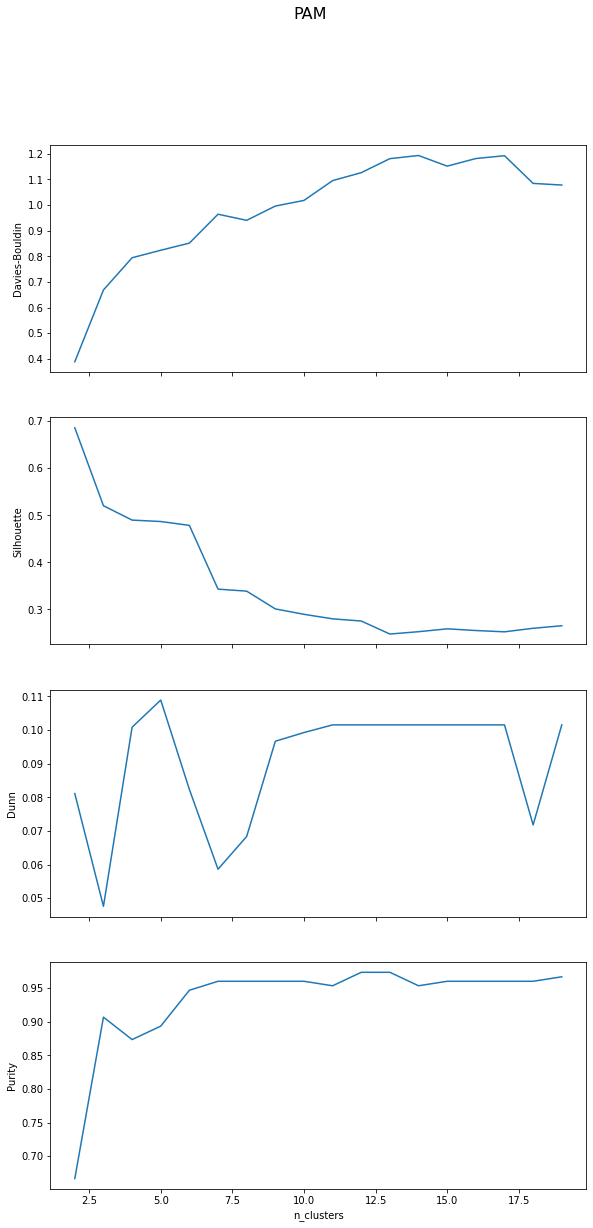

In [11]:
PAM_parameters(iris)

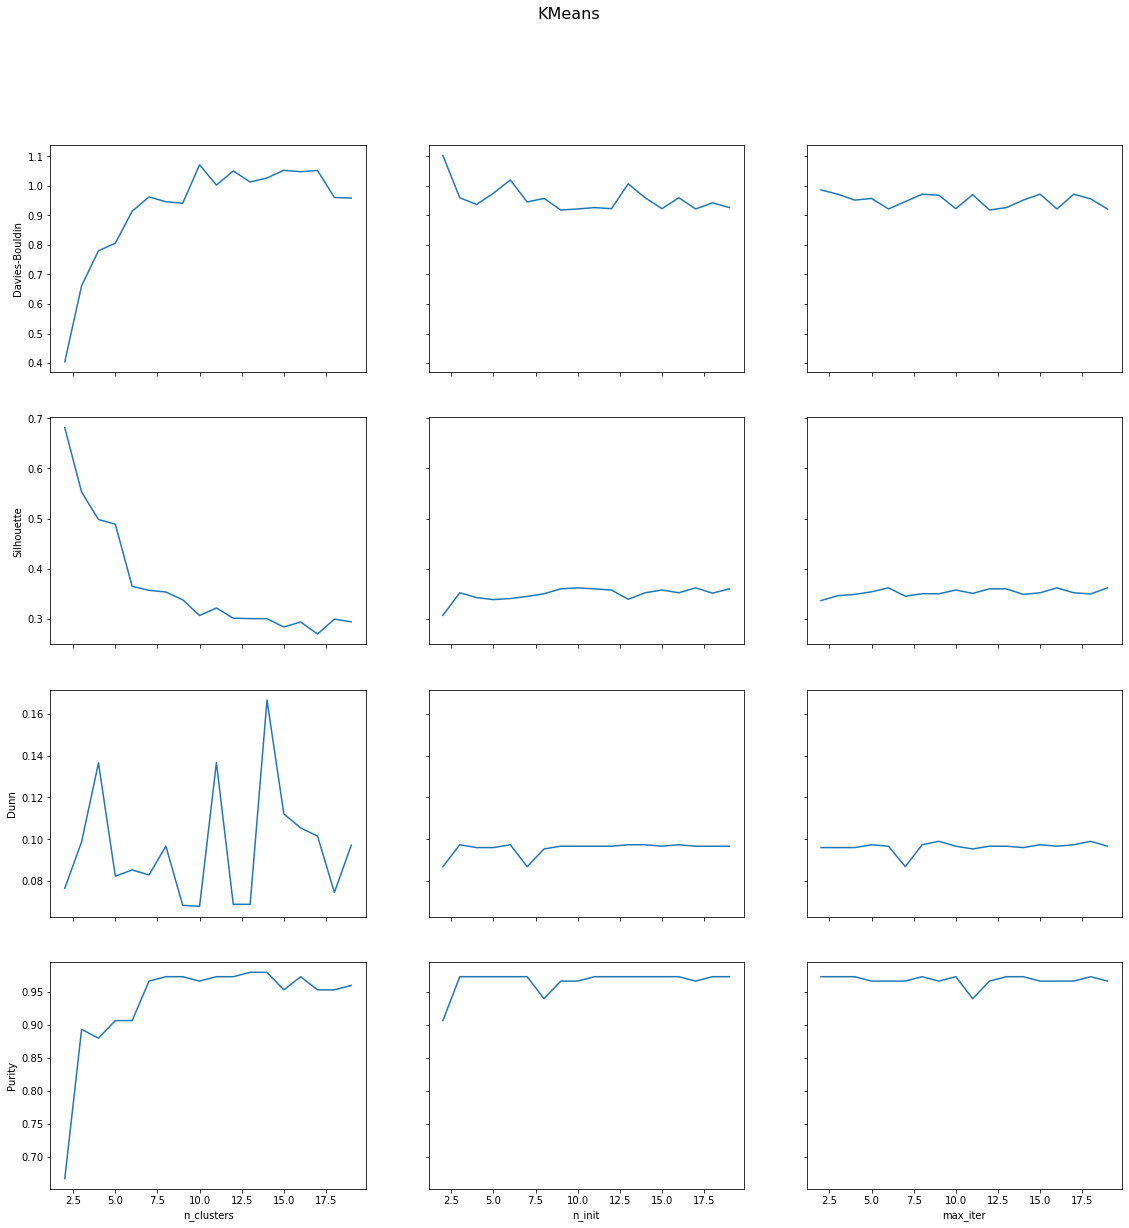

In [12]:
KMeans_parameters(iris)

Purity rośnie wraz ze wzrostem liczby klastrów, ponieważ patrzy na to, czy klasy znajdują się w pojedynczym klastrze.

Silhouette maleje z ilością klastrów, ponieważ kiedy ilość klastrów rośnie to zmiejsza się odległość między nimi.

Dla Davies-Bouldin istnieje optymalna ilość klastrów (zależnie od zbioru).

Parametry ``n_init`` i ``max_iter`` nie mają tak dużego wpływu na wyniki.

# Glass

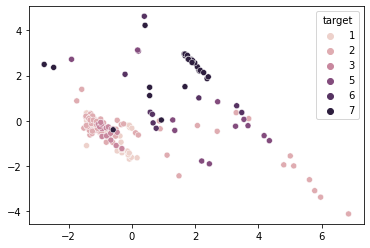

In [13]:
make_plot(glass)

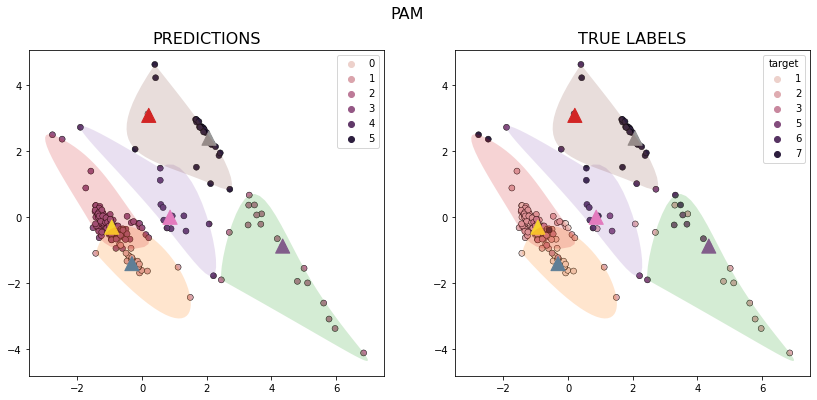

Davies-Bouldin: 1.032672140237961
Silhouette: 0.43838418315650257
Dunn: 0.06599915687545424
Purity: 0.5607476635514018


In [33]:
model = KMedoids(n_clusters=glass['target'].nunique(), method='pam')
model.fit(glass['data'])
plot_clusterization(glass, glass['target'], model, 'PAM')
preds = model.predict(glass['data'])
print('Davies-Bouldin:', davies_bouldin_score(glass['data'], preds))
print('Silhouette:', silhouette_score(glass['data'], preds))
print('Dunn:', dunn_score(glass['data'], preds))
print('Purity:', purity_score(glass['target'], preds))

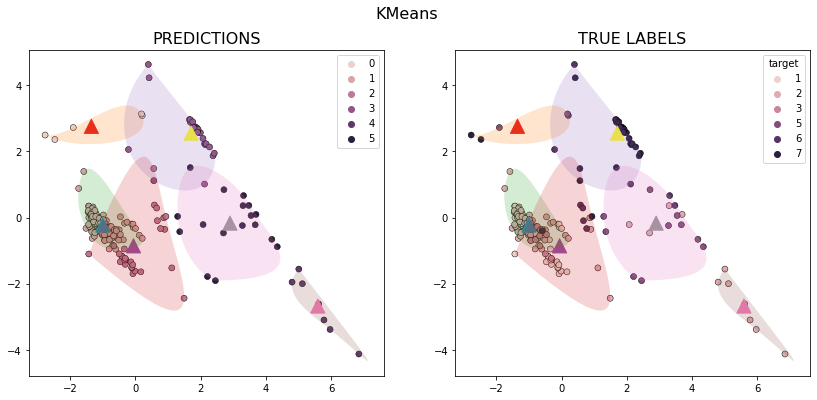

Davies-Bouldin: 0.964919743734689
Silhouette: 0.4519785341078629
Dunn: 0.04635306322808011
Purity: 0.5887850467289719


In [15]:
model = KMeans(n_clusters=glass['target'].nunique())
model.fit(glass['data'])
plot_clusterization(glass, glass['target'], model, 'KMeans')
preds = model.predict(glass['data'])
print('Davies-Bouldin:', davies_bouldin_score(glass['data'], preds))
print('Silhouette:', silhouette_score(glass['data'], preds))
print('Dunn:', dunn_score(glass['data'], preds))
print('Purity:', purity_score(glass['target'], preds))

No standarization
Davies-Bouldin: 0.8571083306432072
Silhouette: 0.2477102165293905
Dunn: 0.03349981043700586
Purity: 0.6635514018691588

With standarization
Davies-Bouldin: 0.9965898504170951
Silhouette: 0.22432107115255379
Dunn: 0.03282345933217096
Purity: 0.6822429906542056

-----------------------

Euclidean metric
Davies-Bouldin: 0.8571083306432072
Silhouette: 0.2477102165293905
Dunn: 0.03349981043700586
Purity: 0.6635514018691588

Manhattan metric
Davies-Bouldin: 0.8563360553883975
Silhouette: 0.2502043061215157
Dunn: 0.04505547309180119
Purity: 0.6915887850467289

Chebyshev metric
Davies-Bouldin: 1.0191227146720694
Silhouette: 0.26426045161119943
Dunn: 0.044963670808804625
Purity: 0.6822429906542056


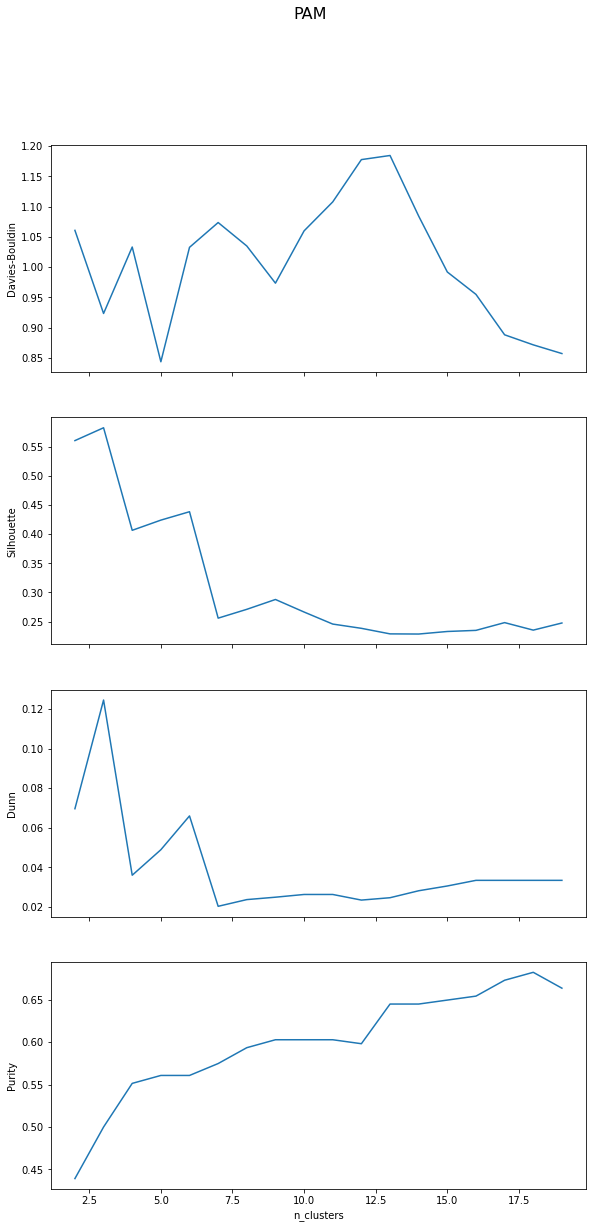

In [16]:
PAM_parameters(glass)

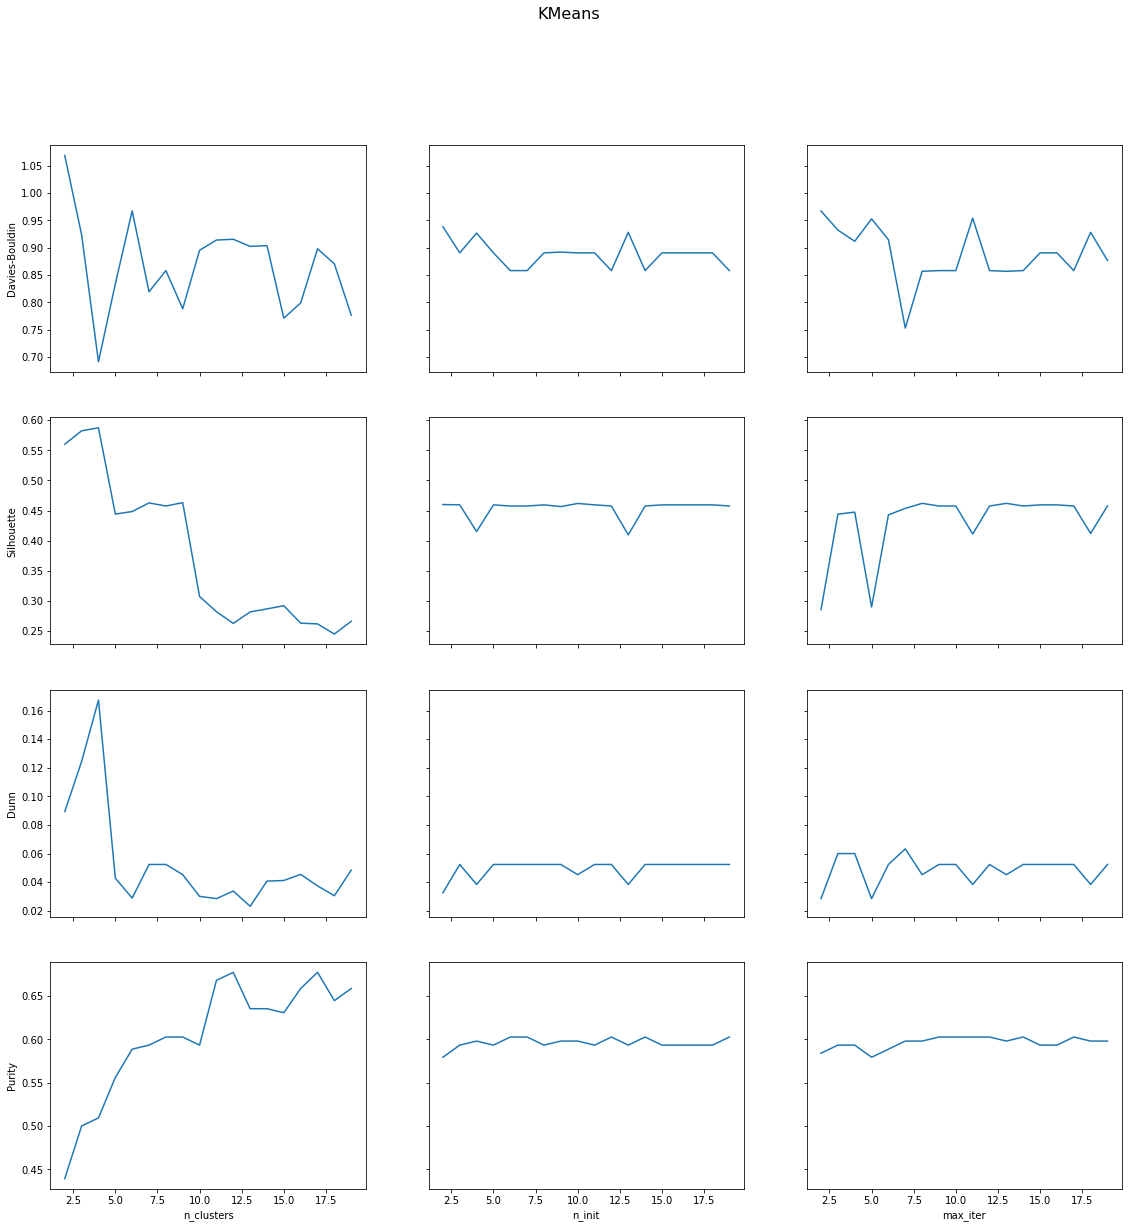

In [17]:
KMeans_parameters(glass)

# Wine

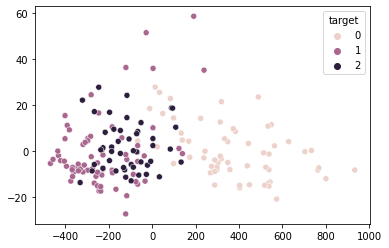

In [18]:
make_plot(wine)

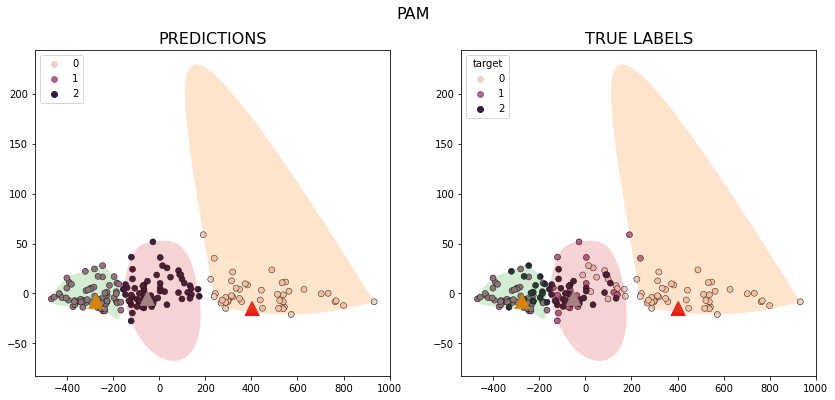

Davies-Bouldin: 0.5316801818576816
Silhouette: 0.5708303868116225
Dunn: 0.022916707615641897
Purity: 0.7078651685393258


In [22]:
model = KMedoids(n_clusters=wine['target'].nunique(), method='pam')
model.fit(wine['data'])
plot_clusterization(wine, wine['target'], model, 'PAM')
preds = model.predict(wine['data'])
print('Davies-Bouldin:', davies_bouldin_score(wine['data'], preds))
print('Silhouette:', silhouette_score(wine['data'], preds))
print('Dunn:', dunn_score(wine['data'], preds))
print('Purity:', purity_score(wine['target'], preds))

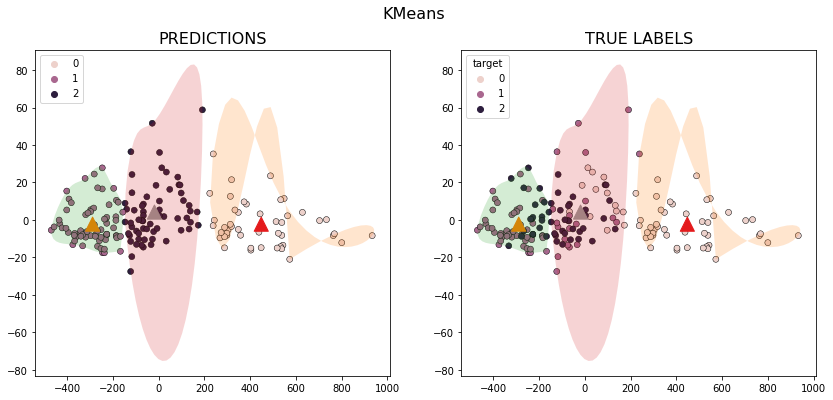

Davies-Bouldin: 0.5342431775436273
Silhouette: 0.571138193786884
Dunn: 0.01626043915542385
Purity: 0.702247191011236


In [24]:
model = KMeans(n_clusters=wine['target'].nunique())
model.fit(wine['data'])
plot_clusterization(wine, wine['target'], model, 'KMeans')
preds = model.predict(wine['data'])
print('Davies-Bouldin:', davies_bouldin_score(wine['data'], preds))
print('Silhouette:', silhouette_score(wine['data'], preds))
print('Dunn:', dunn_score(wine['data'], preds))
print('Purity:', purity_score(wine['target'], preds))

No standarization
Davies-Bouldin: 0.611097117519003
Silhouette: 0.4620058542246939
Dunn: 0.07934875635719033
Purity: 0.7303370786516854

With standarization
Davies-Bouldin: 1.613762921782548
Silhouette: 0.11917633706823061
Dunn: 0.23283777412457174
Purity: 0.9382022471910112

-----------------------

Euclidean metric
Davies-Bouldin: 0.611097117519003
Silhouette: 0.4620058542246939
Dunn: 0.07934875635719033
Purity: 0.7303370786516854

Manhattan metric
Davies-Bouldin: 0.6011086075632717
Silhouette: 0.39657144279318507
Dunn: 0.05856582649461861
Purity: 0.7528089887640449

Chebyshev metric
Davies-Bouldin: 0.6224549201899644
Silhouette: 0.4762141084797461
Dunn: 0.06394394591276144
Purity: 0.7303370786516854


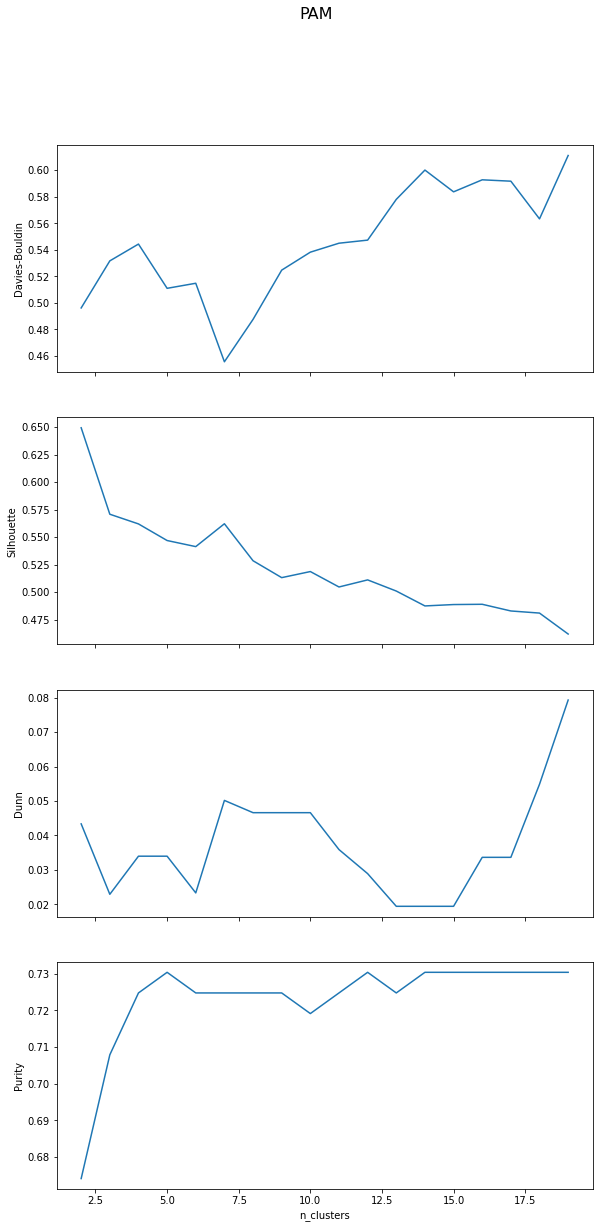

In [25]:
PAM_parameters(wine)

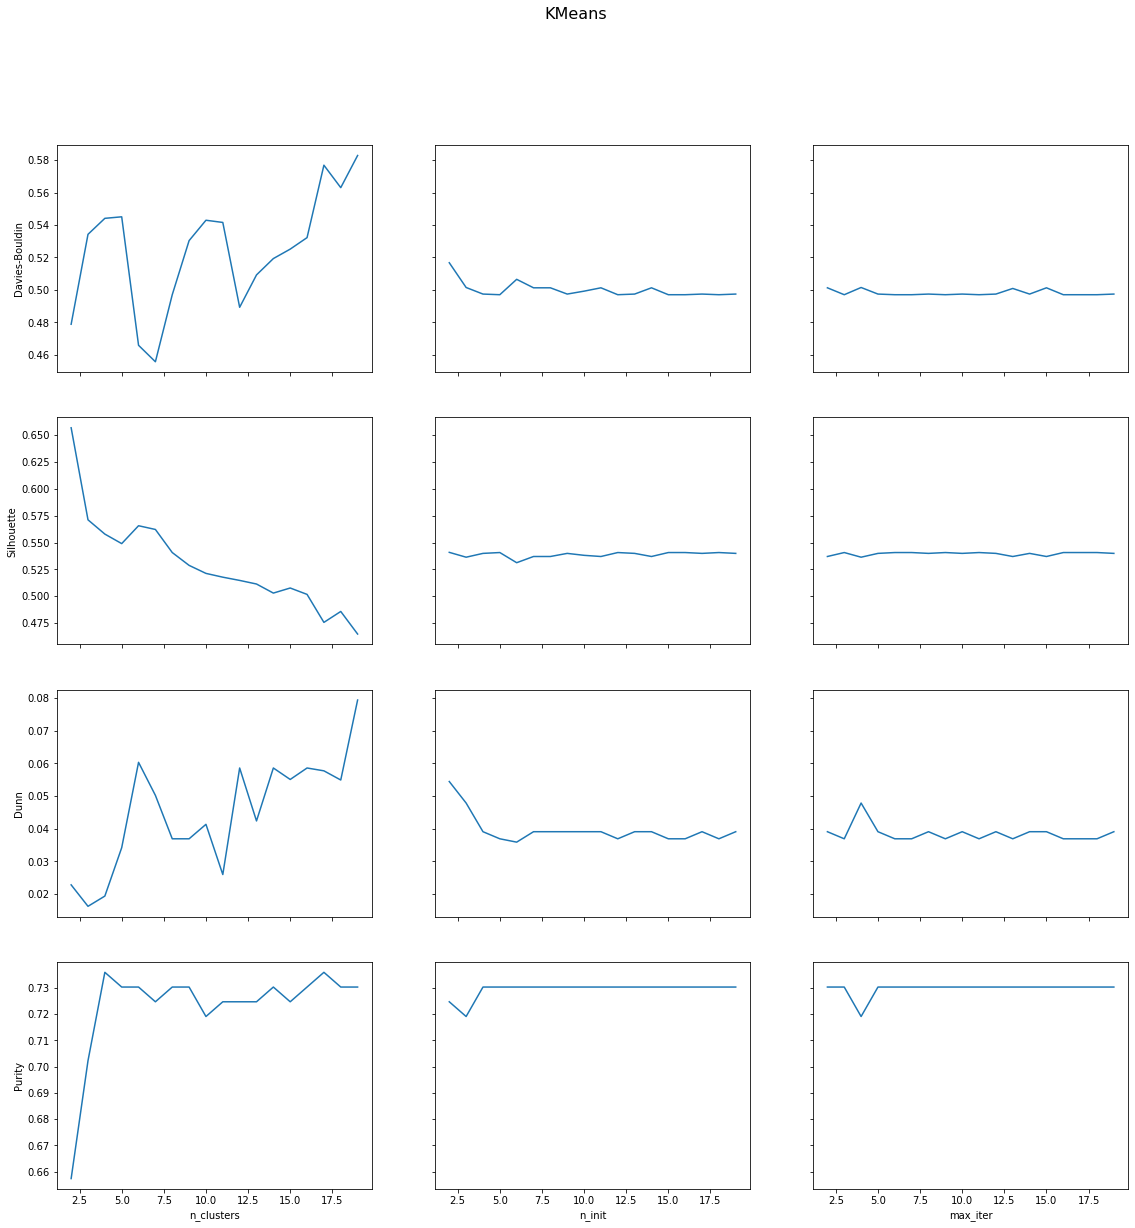

In [26]:
KMeans_parameters(wine)

# Seeds

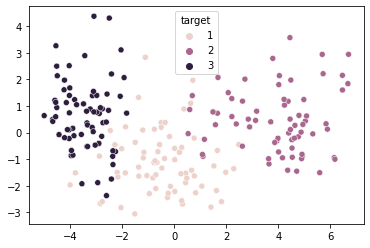

In [27]:
make_plot(seeds)

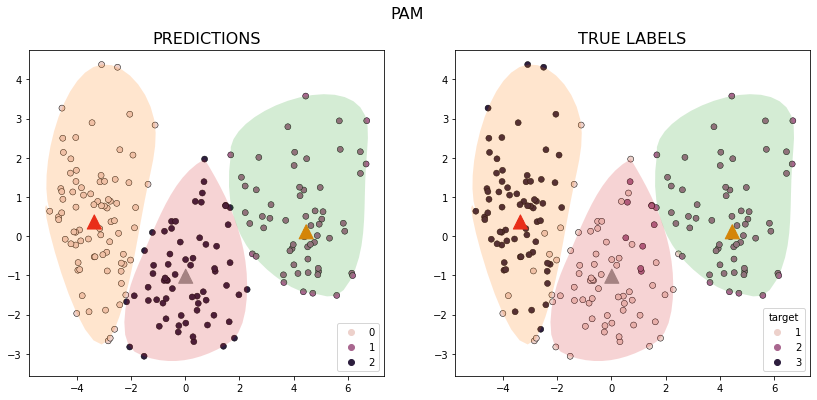

Davies-Bouldin: 0.7544432562728495
Silhouette: 0.4681390800859686
Dunn: 0.04951009479047996
Purity: 0.8904761904761904


In [28]:
model = KMedoids(n_clusters=seeds['target'].nunique(), method='pam')
model.fit(seeds['data'])
plot_clusterization(seeds, seeds['target'], model, 'PAM')
preds = model.predict(seeds['data'])
print('Davies-Bouldin:', davies_bouldin_score(seeds['data'], preds))
print('Silhouette:', silhouette_score(seeds['data'], preds))
print('Dunn:', dunn_score(seeds['data'], preds))
print('Purity:', purity_score(seeds['target'], preds))

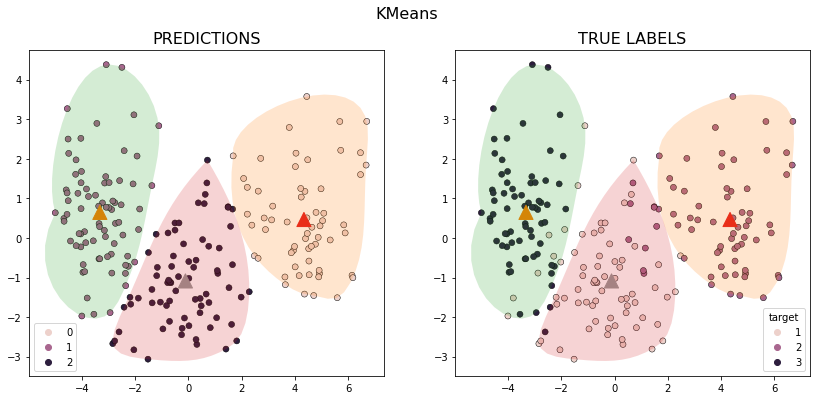

Davies-Bouldin: 0.7533139698796463
Silhouette: 0.4719337319126887
Dunn: 0.08550680193416635
Purity: 0.8952380952380953


In [29]:
model = KMeans(n_clusters=seeds['target'].nunique())
model.fit(seeds['data'])
plot_clusterization(seeds, seeds['target'], model, 'KMeans')
preds = model.predict(seeds['data'])
print('Davies-Bouldin:', davies_bouldin_score(seeds['data'], preds))
print('Silhouette:', silhouette_score(seeds['data'], preds))
print('Dunn:', dunn_score(seeds['data'], preds))
print('Purity:', purity_score(seeds['target'], preds))

No standarization
Davies-Bouldin: 0.9026820804524703
Silhouette: 0.30120320486285346
Dunn: 0.06870518695675543
Purity: 0.8952380952380953

With standarization
Davies-Bouldin: 1.0445562758786564
Silhouette: 0.25714825694017857
Dunn: 0.12747562380197855
Purity: 0.919047619047619

-----------------------

Euclidean metric
Davies-Bouldin: 0.9026820804524703
Silhouette: 0.30120320486285346
Dunn: 0.06870518695675543
Purity: 0.8952380952380953

Manhattan metric
Davies-Bouldin: 0.9030271200568897
Silhouette: 0.2999139405142271
Dunn: 0.08206978606819629
Purity: 0.9047619047619048

Chebyshev metric
Davies-Bouldin: 0.9321007537125815
Silhouette: 0.33725267473571274
Dunn: 0.04478428317673414
Purity: 0.8952380952380953


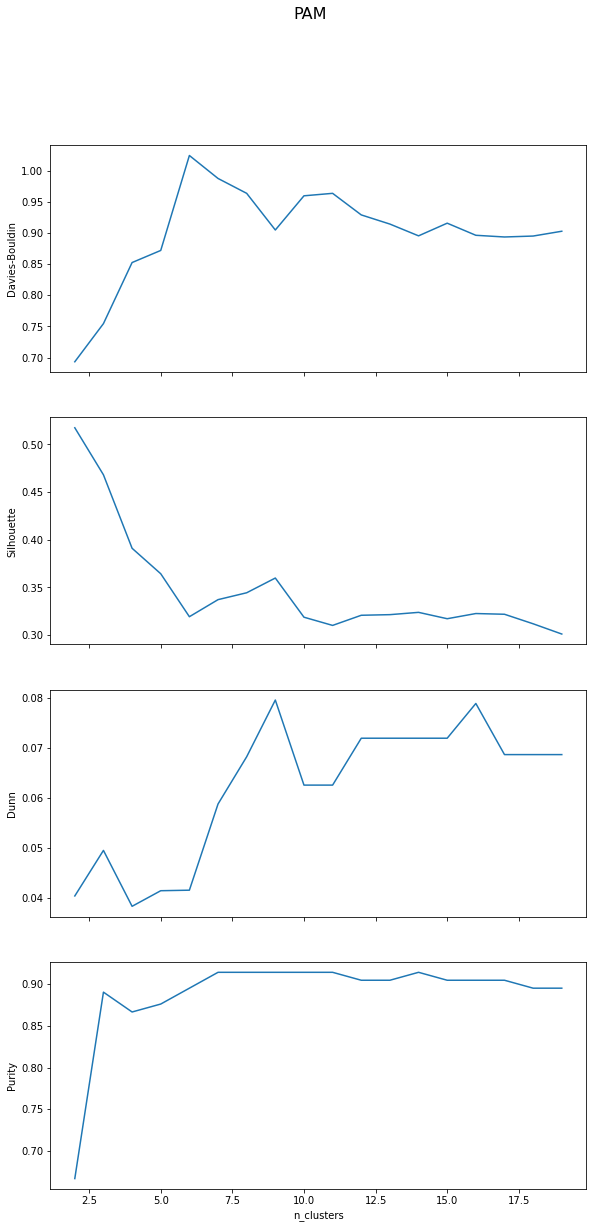

In [30]:
PAM_parameters(seeds)

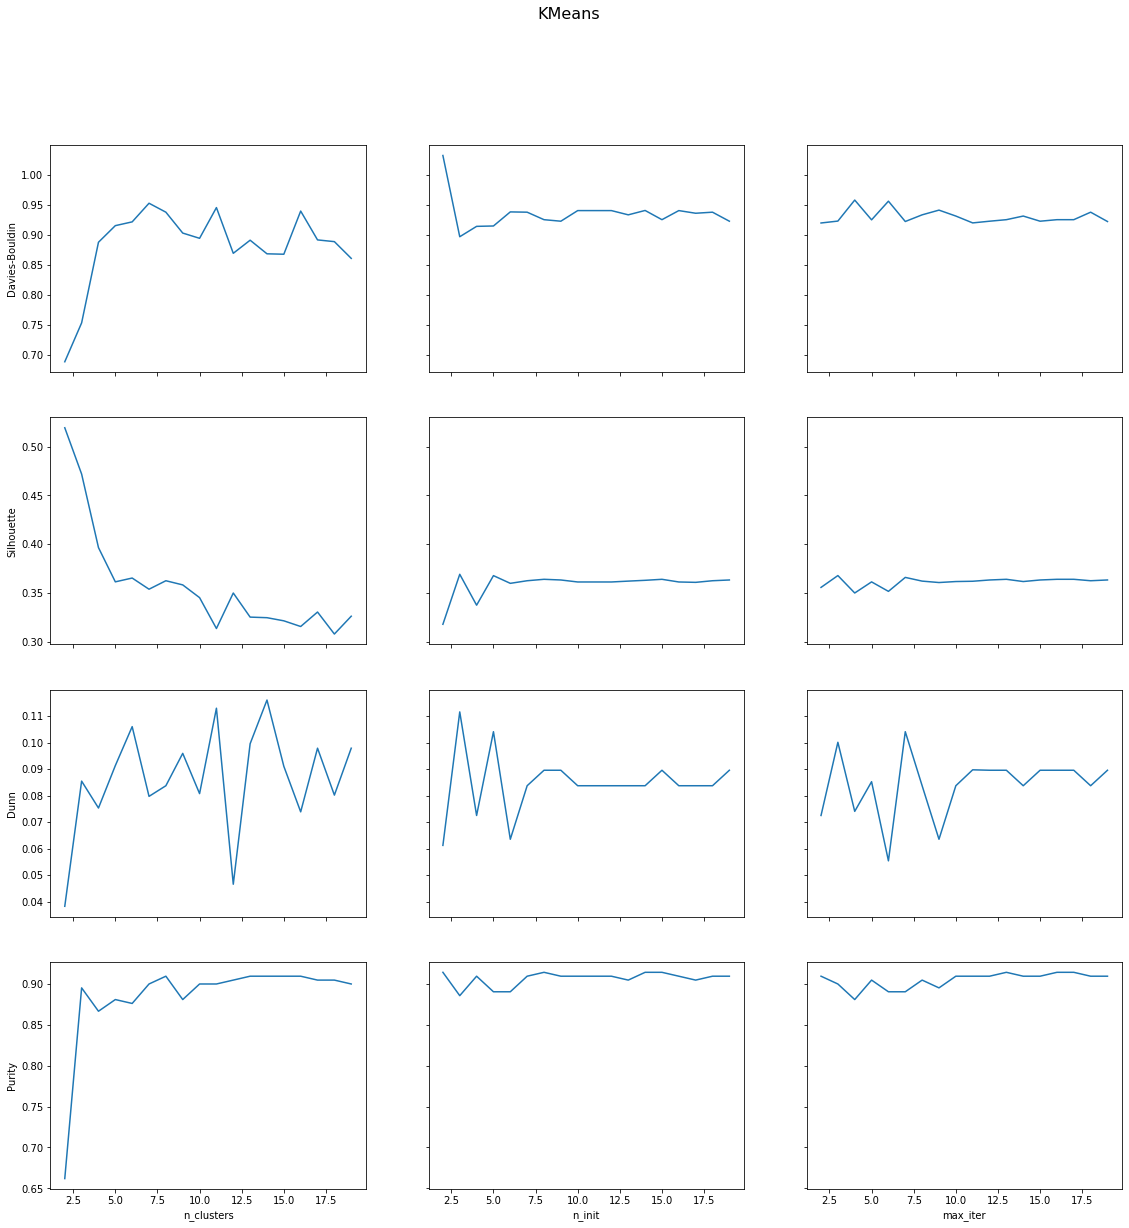

In [31]:
KMeans_parameters(seeds)